In [97]:
from data_processing.neural_networks.LSTM_Long_Short_Term_Memory.LSTM_torch_class import LSTM_torch
#from data_processing.neural_networks.nn_helper_functions import init_weights_LSTM as init_weights
import torch
import torch.nn as nn
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#tensorboard --logdir 'runs\LSTM_pytorch_full' --host localhost --port 8888
from IPython.display import clear_output
clear_output()

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
#from sklearn.preprocessing import MinMaxScaler
#from sklearn import linear_model
#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
clear_output()

# Solved case using pytorch [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer.
* Model reads sequence and predicts next entry.
* Can predict further by updating sequence with previous prediction and reusing model.
## Read data & (OPTIONAL) check trends



torch.Size([132, 3])

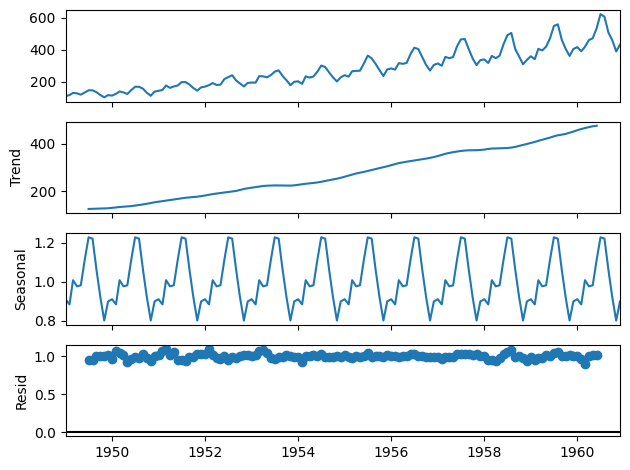

In [99]:
df = pd.read_csv(os.path.join('data_processing','media','airline-passengers.csv'), index_col=0, parse_dates=True)
timeseriesOG    = torch.tensor(df["Passengers"].values, dtype = torch.float, device=device).reshape(-1,1)
result          = seasonal_decompose(df, model='multiplicative')
result.plot();

data_trend      = result.trend.to_numpy()[6:-6]
data_seasonal   = result.seasonal.to_numpy()[6:-6]
data_residual   = result.resid.to_numpy()[6:-6]
LEN_DATA = len(data_trend)

data_trend      = torch.tensor(data_trend   , device = device, dtype = torch.float)
data_seasonal   = torch.tensor(data_seasonal, device = device, dtype = torch.float)
data_residual   = torch.tensor(data_residual, device = device, dtype = torch.float)
data_concat     = torch.vstack([data_trend,data_seasonal,data_residual]).T
data_concat.shape

## Prepare training and "validaion" slices of data

For training $\rightarrow$ 1 step ahead.
* slice(from, to, step), 'to' not included
* get all data except last element

In [100]:
LOOKBACK = 30
slices_train = [slice(i,i + LOOKBACK,1) for i in range(LEN_DATA - LOOKBACK + 1)]
NUM_SLICES = len(slices_train)
slices_train[-1], data_trend.shape, data_trend[slices_train[-1]].shape

(slice(102, 132, 1), torch.Size([132]), torch.Size([30]))

For testing `N_FORWARD` steps ahead.
* get up to last `N_FORWARD` entries
* generate input slice and output slice

In [101]:
N_FORWARD = 10
slices_test_input    = [slice(i              , i + LOOKBACK              , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_output   = [slice(i + LOOKBACK   , i + LOOKBACK + N_FORWARD  , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_input[-1], slices_test_output[-1]

(slice(92, 122, 1), slice(122, 132, 1))

In [102]:
class LSTM(nn.Module):

    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_features = num_features

        self.lstm       = nn.LSTM(num_features, hidden_dim)
        self.lin = nn.Linear(hidden_dim, num_features)

    def forward(self,  data):
        return self.calc(data)[0]
    
    def calc(self,dataset, c0 = None, h0 = None):
        (c0, h0) = torch.zeros(size = (2,1,self.hidden_size), device=device, dtype = torch.float) if c0 is None else (c0, h0)
        out, states_out = self.lstm(dataset, (c0, h0))
        out = self.lin(out[-1])
        return  out, states_out 
    
    @torch.no_grad()
    def test(self, dataset, iter_input, iter_output):
        buffer          = dataset[iter_input].clone()
        data_buffer_old = buffer.clone()
        (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
        predict = torch.zeros(size = (N_FORWARD, self.num_features))
        for i in range(N_FORWARD):
            out, (ck, hk) = self.calc(buffer, ck, hk)
            (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
            predict[i]  = out   
            buffer[:-1] = data_buffer_old[1:]
            buffer[-1]  = out
            data_buffer_old = buffer.clone()

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , dataset[iter_input][:,k]    .cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), dataset[iter_output][:,k]   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict[:,k]                .cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()
        

# HIDDEN_SIZE = 100
# train_data = timeseriesOG#data_seasonal.reshape(-1,1)#data_seasonal
# saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_full_{HIDDEN_SIZE}_{train_data.size(1)}.pht')

# net = LSTM(train_data.size(1),HIDDEN_SIZE).to(device)

# if os.path.exists(saved_state_path):
#     saved_state_dict = torch.load(saved_state_path)
#     net.load_state_dict(saved_state_dict)

# criterion = nn.MSELoss()
# optimizer = Adam(net.parameters(), lr = 1e-4)#, weight_decay=1e-5)

# s=  10
# net(train_data[slices_train[s]]).shape
# net.test(train_data, slices_test_input[s], slices_test_output[s])

In [106]:
class LSTM(nn.Module):

    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_features = num_features

        self.lstm = nn.LSTM(num_features, hidden_dim)
        self.lin  = nn.Linear(hidden_dim, num_features)

    def forward(self,  data):
        #(c0, h0) = torch.zeros(size = (2, 1, self.hidden_size), device=device, dtype = torch.float)
        out, states_out = self.lstm(data)#, (c0, h0)
        out = self.lin(out[-1])
        return  out, states_out 
    
    def calc(self,dataset, c0 = None, h0 = None):
        (c0, h0) = torch.zeros(size = (2,1,self.hidden_size), device=device, dtype = torch.float) if c0 is None else (c0, h0)
        out, states_out = self.lstm(dataset, (c0, h0))
        out = self.lin(out[-1])
        return  out, states_out 
    
    @torch.no_grad()
    def test0(self, dataset, iter_input, iter_output):
        
        out, (ck, hk) = self.forward(dataset[iter_input].clone())
        out = out.reshape(1,1)
        predict = torch.zeros(size = (N_FORWARD, self.num_features))
        for i in range(N_FORWARD):
            predict[i]  = out  
            out, (ck, hk) = self.lstm(out, (ck, hk))
            out = self.lin(out[-1]).reshape(1,1)

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , dataset[iter_input][:,k]    .cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), dataset[iter_output][:,k]   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict[:,k]                .cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()

    @torch.no_grad()
    def test(self, dataset, iter_input, iter_output):
        buffer          = dataset[iter_input].clone()
        data_buffer_old = buffer.clone()
        (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
        predict = torch.zeros(size = (N_FORWARD, self.num_features))
        for i in range(N_FORWARD):
            out, (ck, hk) = self.calc(buffer, ck, hk)
            (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
            predict[i]  = out   
            buffer[:-1] = data_buffer_old[1:]
            buffer[-1]  = out
            data_buffer_old = buffer.clone()

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , dataset[iter_input][:,k]    .cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), dataset[iter_output][:,k]   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict[:,k]                .cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()
        

HIDDEN_SIZE = 100
train_data = timeseriesOG#data_seasonal.reshape(-1,1)#data_seasonal
saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_full_{HIDDEN_SIZE}_{train_data.size(1)}.pht')

net = LSTM(train_data.size(1),HIDDEN_SIZE).to(device)

# if os.path.exists(saved_state_path):
#     saved_state_dict = torch.load(saved_state_path)
#     net.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(net.parameters(), lr = 1e-4)#, weight_decay=1e-5)

# Train model
learn to predict 1 step ahead
test by predicting N_FORWARD steps into future

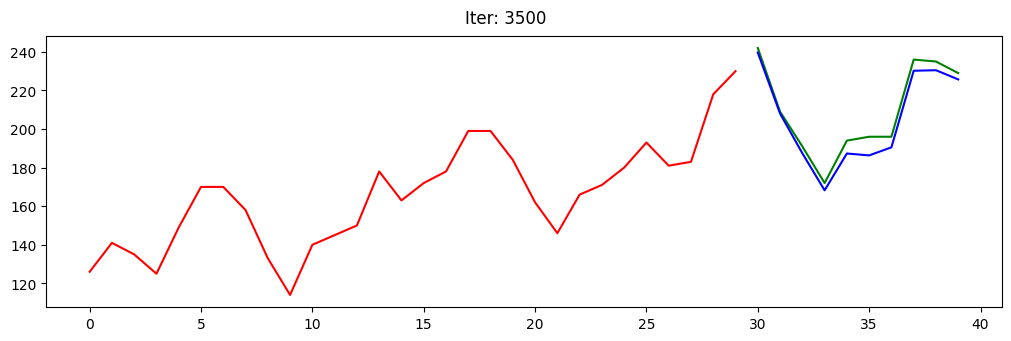

iter:3500, 6.071e+02


In [107]:
NUM_EPOCHS = 3501

now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0

for i in range(NUM_EPOCHS):
    loss2 = 0
    slice_IDX = torch.randperm(NUM_SLICES - 1)
    for j in slice_IDX:
        slc = slices_train[j]
        output = net(train_data[slc])[0]    #input [LOOKBACK,1], output [1]
        y = train_data[slc.stop]            # [1]
        loss   = criterion(output, y)
        loss2 += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # test prediction of N steps forward
    if i % 100 == 0:
        clear_output()
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        net.test(train_data, slices_test_input[s], slices_test_output[s])
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 999 == 0 and i > 1:
         torch.save(net.state_dict(), saved_state_path)
         #clear_output()
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1
    if i % 10 == 0:
        with torch.no_grad():
            print(f'iter:{i}, {loss2:0.3e}')

In [ ]:
class FakeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.num_features = input_size
        self.hidden_size  = hidden_size

        self.Wi         = nn.Linear(in_features=input_size, out_features=4*hidden_size, bias=False, device=device)
        self.Wh         = nn.Linear(in_features=hidden_size, out_features=4*hidden_size, bias=True, device=device)

        self.sigmoid    = nn.Sigmoid()
        self.tanh       = nn.Tanh()

        self.lin        = nn.Linear(hidden_size, input_size)
    
    def LSTM_PASS(self, x_t, c_prev, h_prev):

        gates = (self.Wi(x_t) + self.Wh(h_prev))
        gate_input, gate_forget, gate_cell, gate_output = gates.chunk(4, dim = 1)

        gate_input  = self.sigmoid(  gate_input )
        gate_forget = self.sigmoid(  gate_forget)
        gate_cell   = self.tanh(     gate_cell  )
        gate_output = self.sigmoid(  gate_output)

        c_t         = gate_forget * c_prev + gate_input * gate_cell
        h_t         = gate_output * self.tanh(gate_cell)

        return c_t, h_t
    
    def forward(self, dataset):
        NUM_ITERS = dataset.size(-1)
   
        c_t, h_t = torch.zeros((2,  1, self.hidden_size), device=device, dtype=torch.float)
        for i in range(NUM_ITERS):
            x_t = dataset[:,i].unsqueeze(-1)
            c_t, h_t = self.LSTM_PASS(x_t, c_t, h_t)
        
        return self.lin(h_t), c_t, h_t
    
        #c_hist = torch.zeros((NUM_ITERS + 1, self.hidden_size), device=device, dtype=torch.float)
        #h_hist = torch.zeros((NUM_ITERS + 1, self.hidden_size), device=device, dtype=torch.float)
        #     c_t, h_t = self.LSTM_PASS(x_t, h_hist[i], c_hist[i])
        #     c_hist[i+1], h_hist[i+1] += c_t, h_t
        
        # return self.lin(h_hist[-1])
        
    @torch.no_grad()
    def test(self,x, y):
        x_next, ck, hk        = self.forward(x)
        predict = torch.zeros(size = (N_FORWARD + 1, self.num_features))
        predict[0] = x_next
        for i in range(N_FORWARD):
            ck, hk = self.LSTM_PASS(x_next, ck, hk)
            predict[i+1]  = self.lin(hk)   

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                         , x.flatten()   .cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD )   , y.flatten()   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD + 1), predict[:,k]  .cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()


train_data = df["Passengers"].values
# last slice has no prediction
batch_x = torch.tensor([train_data[sl       ] for sl in slices_train[:-1]], dtype=torch.float).to(device) 
batch_y = torch.tensor([train_data[[sl.stop]] for sl in slices_train[:-1]], dtype=torch.float).to(device)

saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_custom_batch_{HIDDEN_SIZE}.pht')

HIDDEN_SIZE = 100
net3 = FakeLSTM(1, HIDDEN_SIZE).to(device)

if os.path.exists(saved_state_path):
    saved_state_dict = torch.load(saved_state_path)
    net3.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(net3.parameters(), lr = 1e-2)#, weight_decay=1e-5)


3.835e+03


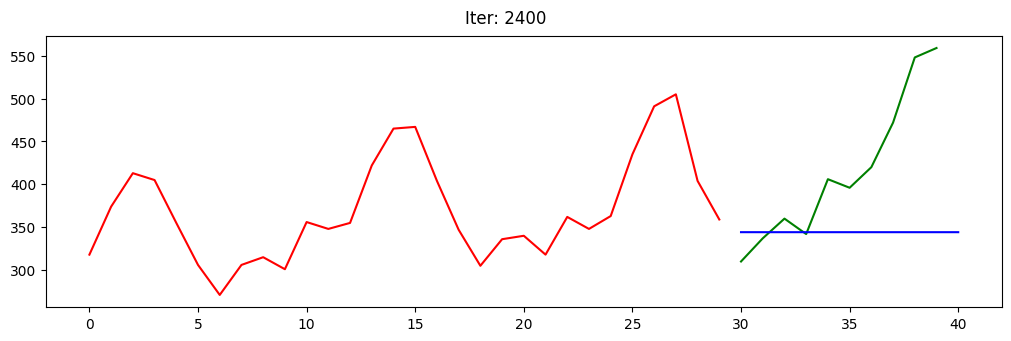

KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 0

now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0

for i in range(NUM_EPOCHS):
    optimizer.zero_grad()

    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]
    batch_y_shuffle = batch_y[ID_shuffle]

    output = net3(batch_x_shuffle)[0]
    loss   = criterion(output, batch_y_shuffle)
    loss.backward()
    optimizer.step()

    # test prediction of N steps forward
    if i % 200 == 0:
        clear_output()
        with torch.no_grad():
            print(f'{loss.item():0.3e}')
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device) 
        net3.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 500 == 0 and i > 1:
         torch.save(net3.state_dict(), saved_state_path)
         #clear_output()
    writer.add_scalar('Training Loss', loss, global_step=step)
    step += 1
    # with torch.no_grad():
    #     print(f'{loss.item():0.3e}')